In [1]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common import make_vec_env
from stable_baselines import A2C, PPO2
from stable_baselines.common.env_checker import check_env
from IPython.display import clear_output
import time
from copy import deepcopy
from ray import tune
from stable_baselines.common.callbacks import BaseCallback

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



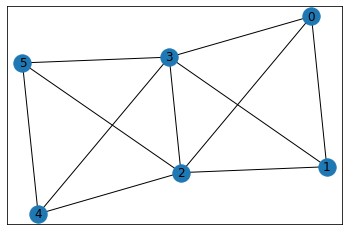

In [2]:
import gym
import w_mac
from collections import defaultdict
import matplotlib as plt
import networkx as nx

d = defaultdict(list)
"""Larger network"""
# data = [(0,2),(0,1),(0,3),(1,2),(1,3),(2,3),(2,4),(3,4),(5,2),(5,3),(5,4),(5,6),(6,7),(6,8),(7,8),(8,9),(9,10),(4,10),(4,6),(5,10),(6,10),(9,6),(8,10)]
"""Smaller netowrk"""
data = [(0,2),(0,1),(0,3),(1,2),(1,3),(2,3),(2,4),(3,4),(5,2),(5,3),(5,4)]
# defaultdict(<type 'list'>, {})
for node, dest in data:
    d[node].append(dest)

G = nx.Graph()
for k,v in d.items():
    for vv in v:
        G.add_edge(k,vv)
nx.draw_networkx(G)

In [3]:
env = gym.make('wmac-graph-v0',graph=G)

self.destinations_list [6, 6, 6, 6, 6]
INITIAL PROBABLITY [1.6713568  0.0532153  2.58072412 9.31775469 3.62829284 7.63731897]
------------SUGGESTED ACTIONS------ [0, 2, 1, 3, 4, 5]
calling create routing table function - 2
self.attack_nodes [6]

------------------------------------------------------


------------------------------------------------------

calling broadcast nbr table function - 3
all queues are empty
Final Routing table {0: {'destination': [2, 1, 3, 4, 5], 'hop_count': [1, 1, 1, 2, 2], 'next_hop': [2, 1, 3, 2, 2], 'id_num': [0]}, 2: {'destination': [0, 1, 3, 4, 5], 'hop_count': [1, 1, 1, 1, 1], 'next_hop': [0, 1, 3, 4, 5], 'id_num': [2]}, 1: {'destination': [0, 2, 3, 4, 5], 'hop_count': [1, 1, 1, 2, 2], 'next_hop': [0, 2, 3, 2, 2], 'id_num': [1]}, 3: {'destination': [0, 2, 1, 4, 5], 'hop_count': [1, 1, 1, 1, 1], 'next_hop': [0, 2, 1, 4, 5], 'id_num': [3]}, 4: {'destination': [2, 3, 5, 0, 1], 'hop_count': [1, 1, 1, 2, 2], 'next_hop': [2, 3, 5, 2, 2], 'id_num': [4]}, 5: 

In [4]:
check_env(env)

AssertionError: The observation returned by the `reset()` method does not match the given observation space

In [ ]:
import tensorflow as tf

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """
    def __init__(self, verbose=0):
        self.is_tb_set = False
        super(TensorboardCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        # Log additional tensor
        if not self.is_tb_set:
            with self.model.graph.as_default():
                tf.summary.scalar('packet_lost', tf.reduce_mean(env.get_packet_lost()))
                self.model.summary = tf.compat.v1.summary.merge_all()
            self.is_tb_set = True
        # Log scalar value (here a random variable)
        value = env.get_packet_lost()
        summary = tf.Summary(value=[tf.Summary.Value(tag='packet_lost', simple_value=value)])
        self.locals['writer'].add_summary(summary, self.num_timesteps)
        return True

In [ ]:
# model = A2C(MlpPolicy, env, verbose=1,tensorboard_log="./a2csmall_newseed/",seed=9)
model = PPO2(MlpPolicy, env, verbose=1,gamma = 0.99,n_steps = 2048,nminibatches=32, learning_rate = 2.5e-4, lam= 0.95, noptepochs= 10,ent_coef= 0.01,cliprange=0.2, tensorboard_log="./PPO2small_newseed/",seed =8, n_cpu_tf_sess = 1)
model.learn(total_timesteps=1500000, callback=TensorboardCallback())
model.save("PPO2_small_newseed2")
# model.save("A2C_NEW")

In [ ]:
del model # remove to demonstrate saving and loading

In [ ]:
"""Code to test the trained model with render function"""

model = PPO2.load("PPO2_small_newseed2")

obs = env.reset()
info = env.get_queue_size()
count = 0
while count < 5000:
    action, _states = predict(obs, info)    
    obs, rewards, done, info = env.step(action)
    env.render()
    count = count + 1
    time.sleep(3)
    clear_output(wait = True)
    if done:
        env.render()
        break

In [ ]:
"""Evaluate trained model for PPO2 and A2C, calulate the mean time steps and mean packet lost for plotting a graph"""

import numpy as np
model = PPO2.load("PPO2_small_newseed2")
# model = A2C.load("A2C_NEW")


timesteps_list = []
packet_lost = []
for i in range(10000):
    obs = env.reset()
    timestep = 0
    done = False
    while done != True:
        timestep += 1
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        pkt_lost = env.get_packet_lost()
#         print(timestep)  
    timesteps_list.append(timestep)
    packet_lost.append(pkt_lost)
#     print(timesteps_list)
print(np.mean(timesteps_list))
print(np.mean(packet_lost))

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

"""Plot graph for baseline, A2C and PPO2 performance comparison"""
labels = ['A2C', 'PPO2']
Packetlost_means = [1.54, 0.2]
Timesteps_means = [86, 40]


# labels = ['DSDV+TDMA', 'PPO2']
# Packetlost_means = [0, 0.2]
# Timesteps_means = [31, 40]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Packetlost_means, width, label='Packetlost')
rects2 = ax.bar(x + width/2, Timesteps_means, width, label='Timesteps')

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()